In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as sk
import scipy.signal
import os
import sys
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Part1: Localization

In [2]:
def IrisLocalization(image):
    """Give a file path to an iris image, return two lists of parameters of the
    inner and outer circles. The first list is the inner circle and the second
    list is the outer circle. The first number is x coordinate of the circle, 
    the second number is the y coordinate, and the last one is the radius of the
    circle."""
    
    # Step 1: Project the image on x-axis and y-axis, the minima are considered 
    # the center of the pupil.
    
    #plt.imshow(image)
    #plt.show()
    xp = np.argmin(np.sum(image, axis=0)[100:180])+100
    yp = np.argmin(np.sum(image, axis=1)[100:180])+100
    
    
    # Step 2: Find a reasonable threshold to find a more accurate pupil 
    # coordinates. Repeat the step twice for a more accurate estimate.
    
    for i in range(2):
        region = image[yp-60:yp+60, xp-60:xp+60]
        retval, dst = cv2.threshold(region, 65, 1, cv2.THRESH_BINARY)
        mask = np.where(dst != 0, 1, 0)
        xp += np.argmin(np.sum(mask, axis=0)) - 60
        yp += np.argmin(np.sum(mask, axis=1)) - 60
    
    # Step 3: Use Canny edge detection and Hough transform to find two circles.
    
    # set two smaller regions to detect edges faster
    width1 = 70
    region_inner = image[max(0, yp-width1):min(280, yp+width1), 
                       max(0, xp-width1):min(320, xp+width1)]
    width2 = 125
    region_outer = image[max(0, yp-width2):min(280, yp+width2), 
                       max(0, xp-width2):min(320, xp+width2)]
    
    # get two parameters for canny edge detection for the inner circle
    var = 0.33
    median = np.median(region_inner)
    para1 = int(max(0, (1.0 - var) * median))
    para2 = int(min(255, (1.0 + var) * median))
    
    # remove noise caused by eye lashes
    inner_filter = cv2.bilateralFilter(region_inner,9,95,95) 
    # use canny edge detector to get an image of inner boundary
    edged_inner = cv2.Canny(inner_filter, para1, para2)
    inner_circles = cv2.HoughCircles(edged_inner, cv2.HOUGH_GRADIENT, 1,300, 
                                     param1=50, param2=10, minRadius=25, 
                                     maxRadius=58)
    region_outer = cv2.bilateralFilter(region_outer,9,95,95) 
    outer_circles = cv2.HoughCircles(region_outer, cv2.HOUGH_GRADIENT, 1,300, 
                                     param1=30, param2=10, minRadius=95, 
                                     maxRadius=114)
    
    # draw circles
    # pupil boundary
    for i in inner_circles[0,:]:
        inner_circle = [int(i[0])+xp-width1, int(i[1])+yp-width1, i[2]]
    # iris boundary
    for i in outer_circles[0,:]:
        outer_circle = [int(i[0])+xp-width2, int(i[1])+yp-width2, i[2]]
    #plt.imshow(image)
    #plt.show()
    return (inner_circle, outer_circle)

# Part1: Image Quality Selection

In [3]:
# Helper function for quality selection.

def find_roi(img, with_boundary=False):
    # Find two regions on each side of the pupil
    # If within_boundary == True, return the side length of these regions(for ajustable f[i])
    inner_x, inner_y, inner_r = map(int, map(int, IrisLocalization(img)[0]))
    outer_x, outer_y, outer_r = map(int, map(int, IrisLocalization(img)[1]))
    area_1_x = max(0, inner_x-inner_r-60)
    area_2_x = inner_x+inner_r
    area_y = inner_y - 30
    area_1_h = 60
    area_2_h = 60
    area1 = img[area_y:(area_y+60), area_1_x:(area_1_x+60)]
    area2 = img[area_y:(area_y+60), area_2_x:(area_2_x+60)]
    if with_boundary == False:
        return area1, area2
    else:
        boundary_dict = {'area_1_h':area_1_h, 'area_2_h':area_2_h}
        return area1, area2, boundary_dict

In [4]:
# Helper function for quality selection.

def draw_roi(img, name):
    #draw the ROIs on img
    inner_x, inner_y, inner_r = map(int, map(int, IrisLocalization(img)[0]))
    outer_x, outer_y, outer_r = map(int, map(int, IrisLocalization(img)[1]))
    area_1_x = max(0,inner_x-inner_r-64)
    area_2_x = inner_x+inner_r
    area_y = inner_y - 30
    area_1_h = 60
    area_2_h = 60
    img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.circle(img_bgr, (inner_x, inner_y), inner_r, (255, 0, 0), 2)
    cv2.circle(img_bgr, (outer_x, outer_y), outer_r, (255, 0, 0), 2)
    cv2.rectangle(img_bgr, (area_1_x, area_y), (area_1_x+area_1_h, area_y+area_1_h), (0, 255, 0), 2)
    cv2.rectangle(img_bgr, (area_2_x, area_y), (area_2_x+64, area_y+area_1_h), (0, 255, 0), 2)
    #cv2.imwrite(name, img_bgr)
    plt.figure(figsize=(5, 5))
    plt.imshow(img_bgr, 'gray')
    plt.title(name)

In [5]:
# Helper function for quality selection.

def integ_calc(f_abs, f1, f2):
    #Calculate the integration
    integ = 0
    for u in range(f_abs.shape[0]):
        for v in range(f_abs.shape[1]):
            if f1 <= np.sqrt(np.square(u-30)+np.square(v-30)) <= f2 :
                integ += f_abs[u, v]
    return integ

In [6]:
# Helper function for quality selection.

def feature_calc(img, area_h = None):
    #Calculate the 2D feature 
    f = np.abs(np.fft.fft2(img))
    f_abs = np.abs(np.fft.fftshift(f))
    if area_h == None:
        f = [0, 6, 22, 32]
    else:
        f = [0, area_h*3/32, area_h*11/32, area_h/2]
    F1 = integ_calc(f_abs, f[0], f[1] )
    F2 = integ_calc(f_abs, f[1], f[2])
    F3 = integ_calc(f_abs, f[2], f[3])
    
    return np.array([(F1 + F2 + F3), (F2 / (F1 + F3))])

In [9]:
# you can change directory to your own path
directory = "/Users/tianyi/Desktop/Iris Recognition/CASIA Iris Image Database (version 1.0)"

# read all the images from the directory
def readimage(directory, dataset):
    #read image from dataset
    files = []
    for first_sub in os.listdir(directory):
        for second_sub in os.listdir(directory+"/"+first_sub+"/{}".format(dataset) ):
            if second_sub[-3:] == 'bmp':
                files = files + [directory+"/"+first_sub+"/{}".format(dataset) +"/"+second_sub]
    return files

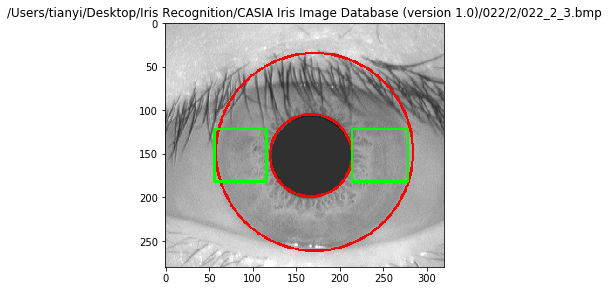

In [10]:
#Example:
file_name_list = readimage(directory, 1) + readimage(directory, 2)

#You can change the number 399
file_name = file_name_list[399]
img = cv2.imread('%s' %  file_name,0)
draw_roi(img, file_name)

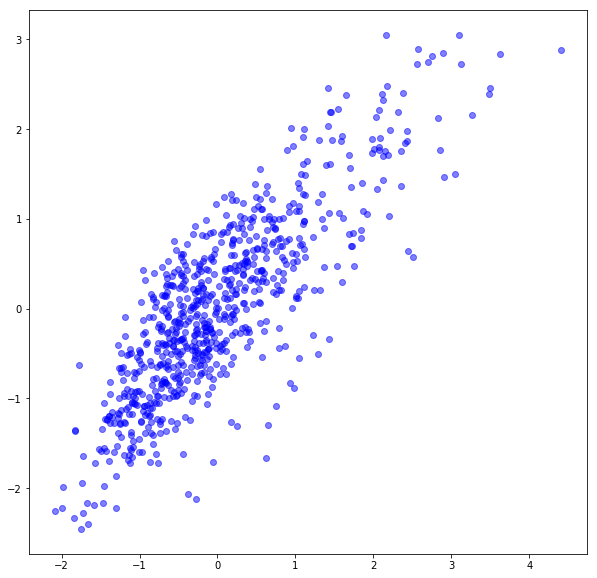

In [12]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

X = []
for file_name in file_name_list:
    img = cv2.imread(file_name,0)
    area1, area2 = find_roi(img)
    x1 = feature_calc(area1)
    x2 = feature_calc(area2)
    x = np.mean((x1, x2), axis=0)
    X.append(x)
X_scaled = preprocessing.scale(X, axis=0)

plt.figure(figsize=(10, 10))
plt.scatter(x=X_scaled[:, 0],y= X_scaled[:, 1], color='b', alpha=0.5 )
plt.show()
#can not be well clustered.

[[-0.82198532 -0.94089626]
 [ 1.85999724  1.66046942]
 [ 0.13105216  0.28096202]]


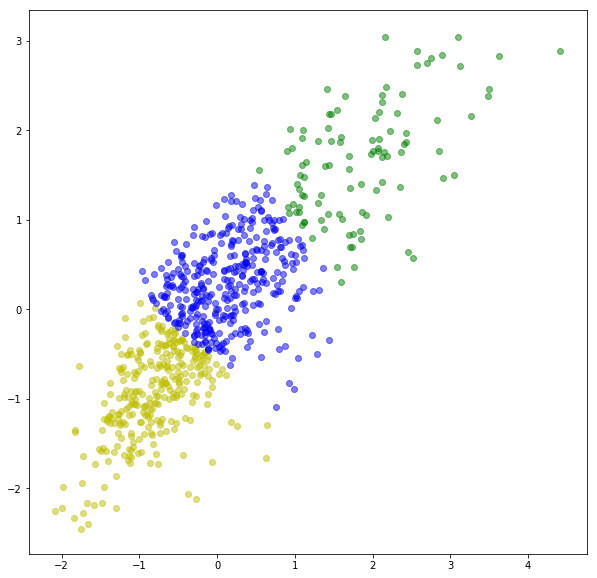

In [13]:
#k-means clustering
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3)
km.fit(X_scaled)
label_km = km.labels_

types = []
for x in label_km:
    if x not in types:
        types.append(x)

cValue = ['r','y','g','b','r','y','g','b','r'] 

plt.figure(figsize=(10, 10))
for t in types:
    X_ = X_scaled[label_km == t]
    plt.scatter(x=X_[:, 0], y=X_[:, 1], color=cValue[t+1], alpha=0.5 )
print(km.cluster_centers_)
# diveded into Occluded, Clear, Blurred.

In [14]:
#Helper function for quality assessnent.

def readimage_sub(directory, first_sub, dataset):
    files = []
    for second_sub in os.listdir(directory+"/"+first_sub+"/{}".format(dataset) ):
        if second_sub[-3:] == 'bmp':
            files = files + [directory+"/"+first_sub+"/{}".format(dataset) +"/"+second_sub]
    return files

def quality_accessment(file_name_list):
    """get the best quality image in the list given"""
    X = []
    for file_name in file_name_list:
        img = cv2.imread(file_name,0)
        area1, area2 = find_roi(img)
        x1 = feature_calc(area1)
        x2 = feature_calc(area2)
        x = np.mean((x1, x2), axis=0)
        X.append(x)
    X = np.asarray(X)
    Mean = np.mean(X, axis = 0)
    Sd = np.std(X, axis = 0)
    X_clear = km.cluster_centers_[0]*Sd+Mean
    best_index =  np.argmin(np.linalg.norm(X-X_clear,axis=1))
    #print(file_name_list[best_index])
    return file_name_list[best_index]

In [15]:
def best_image_lst(directory):
    """give the directory, get the best quality image for each eye in both 
    testing sets and training sets"""
    
    best_1 = []
    best_2 = []
    subs = os.listdir(directory)
    for sub in subs:
        file_names_1 = readimage_sub(directory, sub, 1)
        best_1.append(quality_accessment(file_names_1))
        file_names_2 = readimage_sub(directory, sub, 2)
        best_2.append(quality_accessment(file_names_2))
    return best_1, best_2

In [16]:
best_1, best_2 = best_image_lst(directory)
best_1.sort()
best_2.sort()

# We are not going to use the best quality image in the training set to train the 
# feature vectors since the result is not good. However, we will use the best quality
# image in the testing set to get a higher accuracy for prediction

# Part2: Image Processing

In [17]:
def IrisNormalization(circle_p, circle_i,image,theta = 0):
    """give the return value of IrisLocalization, return the normalized image, 
    which is 64*512 """
    
    mapx = np.ndarray((64,512),dtype=np.float32)
    mapy = np.ndarray((64,512),dtype=np.float32)
    for i in range(64):
        for j in range(512):
            theta1 = (2*np.pi*j/512)+theta/180*np.pi
            ratio = i/64
            xp = circle_p[0]+circle_p[2]*np.sin(theta1)
            yp = circle_p[1]+circle_p[2]*np.cos(theta1)
            xi = circle_i[0]+circle_i[2]*np.sin(theta1)
            yi = circle_i[1]+circle_i[2]*np.cos(theta1)
            mapx[i,j] = xp+ratio*(xi-xp)
            mapy[i,j] = yp+ratio*(yi-yp)
    result = cv2.remap(image,mapx,mapy,cv2.INTER_LINEAR)
    return result

In [18]:
def ImageEnhancement(image):
    """give the normalized image, return an enhanced image"""
    # Method 1: as described in the paper.
    
    # Step1: Take average of 16*16 window as approx. illumination
    #illum = np.ndarray((4,32),dtype = np.float32)
    #for i in range(4):
    #    for j in range(32):
    #        illum[i,j] = np.sum(image[(16*i):(16*(i+1)),(16*j):(16*(j+1))])/256
            
    # Step2: Expand the illumination size to 64*512 by bicubic interpolation.
    #illum_whole = cv2.resize(illum, None,fx=16, fy=16, interpolation=cv2.INTER_CUBIC)
    
    # Step3: Subtract the illumination to compensate for lighting conditions.
    #for i in range(64):
    #    for j in range(512):
    #        image[i, j] -= illum_whole[i, j]
            
    # Step4: Enhance the lighting corrected image by histogram equalization
    # Normal histogram equalization
    #equalized_image = cv2.equalizeHist(image)
    # Adaptive histogram equalization
    #clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(32,32))
    #equalized_image = clahe.apply(image)
    
    
    
    # Method 2: Simple histogram equalization for each 32*32 segment of the image
    for i in range(2):
        for j in range(16):
            image[(32*i):(32*(i+1)),(32*j):(32*(j+1))] = cv2.equalizeHist(image[(32*i):(32*(i+1)),(32*j):(32*(j+1))])
    return image

In [19]:
def modulating_function(x, y, f):
    m = np.cos(2*np.pi*f*np.sqrt(x**2+y**2))
    return m

def kernel(x, y, f, sigmaX, sigmaY):
    g = (1/(2*np.pi*sigmaX*sigmaY))*np.exp(-0.5*(x**2/sigmaX**2 + 
                                                 y**2/sigmaY**2))*\
    modulating_function(x, y, f)
    return g

def spatial_filter(f, sigmaX, sigmaY):
    s_filter = np.zeros((8, 8))
    for i in range(8):
        for j in range(8):
            s_filter[i, j] = kernel((j), (i), f, sigmaX, sigmaY)
    return s_filter

def FeatureExtraction(image):
    """give the enhanced image, return the feature vector of the image"""
    
    # Step 1: Find the region of interest.
    roi = image[:48,:]
    
    # Step 2: Get two filtered image.
    filter1 = spatial_filter(0.1, 3, 1.5)
    filtered1 = scipy.signal.convolve2d(roi, filter1, mode='same')
    filter2 = spatial_filter(0.07, 4.5, 1.5)
    filtered2 = scipy.signal.convolve2d(roi, filter2, mode='same')
    
    #Step 3: Get the feature vector.
    feature_vec = np.zeros(1536)
    for i in range(2):
        filtered = [filtered1, filtered2][i]
        for j in range(6):
            for k in range(64):
                mean = np.mean(abs(filtered[j*8:(j+1)*8, k*8:(k+1)*8]))
                sd = np.mean(abs(abs(filtered[j*8:(j+1)*8, k*8:(k+1)*8])- mean))
                feature_vec[i*768 + 128*j + 2*k] = mean
                feature_vec[i*768 + 128*j + 2*k + 1] = sd        
    return feature_vec.reshape(1,-1)

# Part3: Iris Matching

In [20]:
# helper function to get the whole feature vector and test vector

def findfeature(file,theta=0):
    img = cv2.imread(file,0)
    inner_c, outer_c = IrisLocalization(img)
    test = IrisNormalization(inner_c, outer_c, img,theta)
    abc = ImageEnhancement(test)
    feature = FeatureExtraction(abc)
    return(feature)

In [21]:
# all images in the training set are used to get train feature vector
allfile_1 = readimage(directory, 1)
allfile_1.sort()

# as defined in the paper, we need to start from different initial angles 
# to get a relative angle invariant test result
angles = [-9, -6, -3, 0, 3, 6, 9]

# best_2 is defined in the image selection part, for the best result,
# we only use the best quality image in the testing set for each eye.
best_2.sort()

# get all feature vectors in the training set
trainfeature = np.ndarray(shape=(0,1536))
for file in allfile_1:
    for angle in angles:
        trainfeature =  np.concatenate((trainfeature,findfeature(file,angle)) ,axis=0)
        
# get all feature vectors in the testing set
testfeature = np.ndarray(shape=(0,1536))
for file in best_2:
        testfeature =  np.concatenate((testfeature,findfeature(file)) ,axis=0)

In [22]:
def IrisMatching(trainfeature, testfeature, distanceMeasure=1, n_components = 80):
    """for distance measure, 1 is cosine similarity, 2 is euclidean distance, 3 is manhattan distance.
    give train feature and test feature, specify distance measure method, and the number of components in LDA, 
    return the prediction accuracy."""
    
    # response is the y, i.e. the true number of eyes for each feature vector
    response = np.repeat(np.arange(1,109), 21)
    
    # use the feature vector and response to do linear discriminant analysis.
    clf = LinearDiscriminantAnalysis(n_components=n_components)
    clf.fit(trainfeature, response)
    
    # reduce the dimension to the specified number
    new_train_feat = clf.transform(trainfeature)
    new_test_feat = clf.transform(testfeature)
    
    result = []
    if distanceMeasure == 1:
        for i in range(new_test_feat.shape[0]):
            result.append(response[np.argmax(sk.pairwise.cosine_similarity(new_train_feat,new_test_feat[i,].reshape(1,n_components)))])
    elif distanceMeasure == 2:
        for i in range(new_test_feat.shape[0]):
            result.append(response[np.argmin(sk.pairwise.euclidean_distances(new_train_feat,new_test_feat[i,].reshape(1,n_components)))])
    elif distanceMeasure == 3:
        for i in range(new_test_feat.shape[0]):
            result.append(response[np.argmin(sk.pairwise.manhattan_distances(new_train_feat,new_test_feat[i,].reshape(1,n_components)))])
    
    
    # compare answers to get accuracy
    accuracy = sum(np.array(result) == np.arange(new_test_feat.shape[0])+1)/new_test_feat.shape[0]
    return accuracy

# Part4: Performance Evaluation

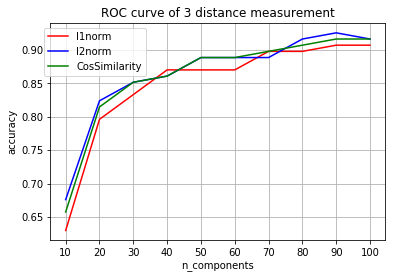

In [25]:
x = np.arange(1,11)*10

# Get the performance for different feature vector dimentions as well as different distance 
# measure methods
l1norm = []
l2norm = []
CosSimilarity = []
for i in range(10, 101, 10):
    l1norm.append(IrisMatching(trainfeature, testfeature, 3, n_components = i))
    l2norm.append(IrisMatching(trainfeature, testfeature, 2, n_components = i))
    CosSimilarity.append(IrisMatching(trainfeature, testfeature, 1, n_components = i))
    
# The starting point for dimensions are 10, the end point is 100
group_labels = ["10","20","30","40","50","60","70","80","90","100"]
plt.title('ROC curve of 3 distance measurement')
plt.xlabel('n_components')
plt.ylabel('accuracy')
 

plt.plot(x, l1norm,'r', label='l1norm')
plt.plot(x, l2norm,'b',label='l2norm')
plt.plot(x, CosSimilarity ,'g',label='CosSimilarity')

plt.xticks(x, group_labels, rotation=0)
 
plt.legend(bbox_to_anchor=[0.3, 1])
plt.grid()
plt.show()